In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tcheading">Table Of Contents</h1>
<div id ="toc"></div>

# Challenge Problem

Problem Background:

David is an enthusiastic data scientist, he just accepted an offer to work in a vehicle company. The first task assigned to him is to identify drivers. He was provided by a large dataset with each row representing a trip. Because there was something wrong with the driver recording system, David doesn't know exactly which trip belongs to which driver. 

So our challenge problem is: could you use your intelligence as well as data analysis skills to help David successfully complete his first task?

Instructions:
    
This is an unsupervised clustering problem. You can use whatever methods you feel comfortble with or even develop your
own algorithms. Please perform the analysis in the following ipython notebook and feel free to keep some notes step by
step. Clustering accuracy is not the only metric we consider (we know it is difficult:) ), what we value most is your thoughts and your ways of solving problems. We welcome different ideas and different approaches.

The file "features.csv" is already loaded into the notebook. Each row represent a single trip, and for each trip we 
extract 81 features. All the features have been normalized so don't worry about the scale. We don't provide the number of clusters(i.e. the number of drivers), you need to come up with a number which you think is reasonable. (hint: the number of drivers is less than 10)

You are welcome to use other packages like scipy, sklearn and so on. Please specify the name of the packages you use. If you've develped your own algorithm, please also list it and attach it to the submission. Thanks.


In [91]:
%matplotlib inline
import pandas as pd
import numpy as np
from pandas.tools.plotting import scatter_matrix
import seaborn
import matplotlib.pyplot as plt
df = pd.read_csv(r'features.csv', header = None)

In [92]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,-0.721068,-0.904710,-0.235318,1.586709,0.143786,-0.226858,-0.610311,-0.833006,-0.428125,-0.378027,...,-0.877109,3.129686,-0.302404,-0.493178,-3.232703,-2.924121,-1.357482,2.585146,2.007905,1.548113
1,-0.404613,0.113062,0.897505,1.819153,1.399129,-0.300533,-0.210631,-0.178289,0.795584,1.440862,...,-0.462745,-0.007327,-0.436273,-0.407124,-0.395230,-0.577987,0.478353,-0.094563,0.331411,-0.244558
2,-0.123777,-0.940535,-0.663909,0.790480,-0.013918,-0.226858,-0.531659,-0.688431,-0.917466,-0.879032,...,0.497257,-0.274554,1.033690,-0.276518,0.210276,0.106163,-0.406284,0.105482,-0.076586,0.280563
3,-0.264248,0.055484,-0.433067,-0.844298,0.162869,-0.226858,0.138486,0.246141,-0.166942,-0.203874,...,-0.084142,-0.874756,-1.495501,0.313123,0.924872,1.196495,0.918112,-0.913131,-1.239995,-0.736224
4,-0.615343,0.875291,-0.078393,-1.453321,1.424701,0.285229,0.579097,0.736663,0.174852,0.040548,...,-2.058909,-0.416706,-0.904475,-0.349632,-0.044972,0.223172,0.630249,-0.744848,-0.531173,-0.080195


In [93]:
len(df)

930

# Data Exploartion
## Feature Distriubtions

In [94]:
df.columns.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

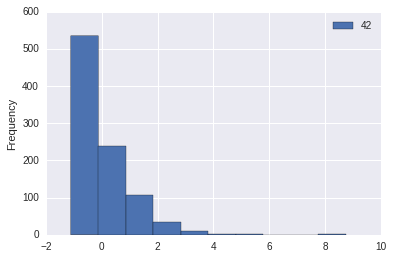

In [122]:
df[[42]].plot(kind='hist')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f607cc8d550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6077362450>]], dtype=object)

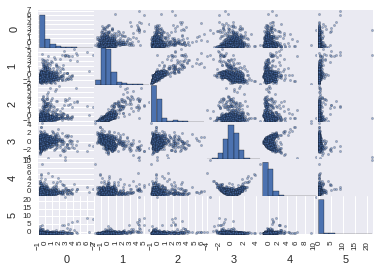

In [117]:
scatter_matrix(df[range(0,6)])

## Feature Correlation - Dimensionality Reduction
Although this data set has 81 features, we can still use KMeans without worry of overburdening our computer. However, as a consistency check, for perhaps trying the same clustering algorithms in reduced dimensional space, we can do a sanity check to determine how correlated varaibles are.

So, the first step is to check for corellated parameters, in order to determine if feature reduction will be a good appproach without losing too much analyzing power. We can use this informaiton later if run-time is too large for k-means.

Grouping Correlated parameters might lead to some insights.

On the plot below, black is highly correlated, and white is uncorrelated

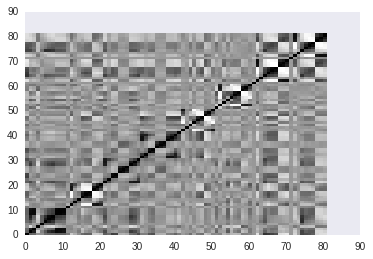

In [77]:
from math import fabs

p_corr = df.corr(method='pearson')
correlations = p_corr.values
plt.pcolor(p_corr)
plt.figure(figsize=(20,20))
plt.show()

In [9]:
correlations_vs_index = {}
for i in range(1,len(correlations)):
    for j in range(i+1,len(correlations)):
        if i == j: continue
        index_string = str(i)+'_'+str(j)
        # since i,j correpsond to the same corellation pair, we don't need to worry about
        # overwriting. Additionally, for sorting purposes, we take the absolute value of the
        # correlation.
        correlations_vs_index[index_string] = fabs(correlations[i][j])
sorted_keys = sorted(correlations_vs_index,key=correlations_vs_index.get)

low_correlation = 0
high_correlation = 0
high_correlation_threshold = 0.9
low_correlation_threshold = 0.1

correlated_keys = []
uncorrelated_keys = []
for key in sorted_keys:
    if correlations_vs_index[key] > high_correlation_threshold:
        high_correlation += 1
        correlated_keys.append(key)
    if correlations_vs_index[key] < low_correlation_threshold:
        low_correlation += 1
        uncorrelated_keys.append(key)
print high_correlation,'variable pairs were highly correlated ( >',high_correlation_threshold,'Person Coefficent)'
print low_correlation,'variable pairs were not very correlated ( <',low_correlation_threshold,'Person Coefficient)'

30 variable pairs were highly correlated ( > 0.9 Person Coefficent)
1374 variable pairs were not very correlated ( < 0.1 Person Coefficient)


# Clustering with KMeans

Kmeans is robust, but makes some assumptions about cluster shape which may not be valid. Generally, kmeans is biased towards ellipsoidal clusters. We can get an estimate for the number of drivers represented in this data set, by running k-means clustering many times, and looking at the variance accounted for by the clustering.

In [78]:
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans
# Convert DataFrame of data to Matrix, X
X = df.as_matrix()

# Try a few different clustering sizes
kmeans = {}
clusters = {}
results = {}
inertia = {}
for i in range(1,10):
    kmeans[i] = KMeans(n_clusters=i)
    kmeans[i].fit(X)
    clusters[i] = kmeans[i].labels_
    inertia[i] = kmeans[i].inertia_
    results[i] = pd.DataFrame([df.index,labels]).T

# Estimating the number of drivers
We can plot the inertia (the distance between centroids and data points for each cluster) as a function of the number of clusters.

The elbow of the distribution suggests the optimum number of clusters, which we can estimate as the number of drivers for the car.

In this case, we see a slight elbow at approximately 3 - 4 clusters, which corresponds to 3-4 unique drivers for this car.

While certainly qualitatively, this is a reasonable number to assume for a family, it is by no means exhaustively correct.

The number of apparent clusters might be affected by the geometry of the clusters themselves, so other clustering metrics should be use to further study.

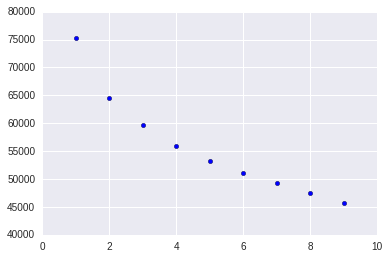

In [79]:
import matplotlib.pyplot as plt

inertia_list = []
clusters = []
for i in range(1,10):
    inertia_list.append(inertia[i])
    clusters.append(i)
x_vals = np.array(clusters)
y_vals = np.array(inertia_list)
plt.scatter(x_vals,y_vals)
plt.show()

# Attempting to Cluster Data With DBScan
K-Means clustering requires that we know the exact number of clusters, as well as making some assumptions about the general shape of clusters. We don't really know that clusters will be ellipsoidal.

To use DB Scan, we have to define an appropriate distance metric to describe the distance between observations, which are represented in our dataframe rows. Once we have defined this distance metric, then we can proceed with clustering the data.

This method has not yet been implimented, but it would serve as an important cross-check to KMeans.

We examine the distribution of distances below:

In [84]:
from scipy.spatial.distance import pdist

# All possible pairs of distances
distance_matrix = pdist(df)


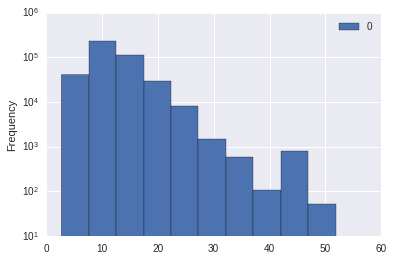

In [86]:
(pd.DataFrame(distance_matrix)).plot(kind='hist',logy=True)